In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip gdrive/MyDrive/identify.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dog Breed Identification/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: Dog Breed Identification/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: Dog Breed Identification/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: Dog Breed Identification/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: Dog Breed Identification/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: Dog Breed Identification/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: Dog Breed Identification/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: Dog Breed Identification/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: Dog Breed Identification/train/83fad0718581a696132c96c166472627.jpg  
  inflating: Dog Breed Identification/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: Dog Breed Identification/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: Dog Breed Identificatio

In [14]:
import pandas as pd
import numpy as np

#constants
num_classes = 12 
seed = 42 
im_size = 299 
batch_size = 32


df = pd.read_csv('Dog Breed Identification/labels.csv')
selected_breed_list = list(df.groupby('breed').count().sort_values(by='id', ascending=False).head(num_classes).index)
df = df[df['breed'].isin(selected_breed_list)]
df['filename'] = df.apply(lambda x: ('train/' + x['id'] + '.jpg'), axis=1)


breeds = pd.Series(df['breed'])
print("total number of breeds to classify",len(breeds.unique()))

df.head(num_classes)

total number of breeds to classify 12


,id,breed,filename
8,003df8b8a8b05244b1d920bb6cf451f9,basenji,train/003df8b8a8b05244b1d920bb6cf451f9.jpg
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound,train/0042188c895a2f14ef64a918ed9c7b64.jpg
12,00693b8bc2470375cc744a6391d397ec,maltese_dog,train/00693b8bc2470375cc744a6391d397ec.jpg
48,013f8fdf6d638c7bb042f5f17e8a9fdc,tibetan_terrier,train/013f8fdf6d638c7bb042f5f17e8a9fdc.jpg
57,0162b3e0144fb1d1ab82fbff3ace9938,shih-tzu,train/0162b3e0144fb1d1ab82fbff3ace9938.jpg
70,01b36cb1b80ab8c3a7d2b7128ad21bdc,samoyed,train/01b36cb1b80ab8c3a7d2b7128ad21bdc.jpg
79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound,train/01e787576c003930f96c966f9c3e1d44.jpg
80,01ee3c7ff9bcaba9874183135877670e,entlebucher,train/01ee3c7ff9bcaba9874183135877670e.jpg
88,021b5a49189665c0442c19b5b33e8cf1,entlebucher,train/021b5a49189665c0442c19b5b33e8cf1.jpg
90,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog,train/022b34fd8734b39995a9f38a4f3e7b6b.jpg


In [15]:
from keras.preprocessing import image

def read_img(img_id, train_or_test, size):
    
    path =  train_or_test + "/" + img_id + ".jpg"
    img = image.load_img(path, target_size=size)
    return image.img_to_array(img)

In [16]:
from sklearn.preprocessing import LabelEncoder
label_enc = LabelEncoder()
np.random.seed(seed=seed)
rnd = np.random.random(len(df))
train_idx = rnd < 0.9
valid_idx = rnd >= 0.9
y_train = label_enc.fit_transform(df["breed"].values)
ytr = y_train[train_idx]
yv = y_train[valid_idx]

In [17]:
from tqdm import tqdm
from keras.applications import xception

x_train = np.zeros((train_idx.sum(), im_size, im_size, 3), dtype='float32')
x_valid = np.zeros((valid_idx.sum(), im_size, im_size, 3), dtype='float32')
train_i = 0
valid_i = 0
for i, img_id in tqdm(enumerate(df['id'])):
    img = read_img(img_id, 'Dog Breed Identification/train', (im_size, im_size))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    if train_idx[i]:
        x_train[train_i] = x
        train_i += 1
    elif valid_idx[i]:
        x_valid[valid_i] = x
        valid_i += 1
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

1355it [00:05, 263.27it/s]

Train Images shape: (1218, 299, 299, 3) size: 326,671,254


In [18]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.25,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow(x_train, 
                                     ytr, 
                                     batch_size=batch_size)


valid_datagen = ImageDataGenerator()

valid_generator = valid_datagen.flow(x_valid, 
                                     yv, 
                                     batch_size=batch_size)


In [19]:

from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Model, Input


base_model = xception.Xception(weights='imagenet', include_top=False)

for layer in base_model.layers:
    layer.trainable = False


x = base_model.output
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)

x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)

predictions = Dense(num_classes, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
import datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint

epochs = 10
learning_rate = 0.001


early_stopping = EarlyStopping(monitor='val_acc', patience=5)
STAMP = "{}_dog_breed_model".format(datetime.date.today().strftime("%Y-%m-%d"))

bst_model_path = "{}.h5".format(STAMP)
model_checkpoint = ModelCheckpoint(bst_model_path,
                                   save_best_only=True,
                                   save_weights_only=False,
                                  verbose=1)




optimizer = RMSprop(lr=learning_rate, rho=0.9)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

hist = model.fit(train_generator,
                 steps_per_epoch=train_idx.sum() // batch_size,
                 epochs=epochs, callbacks=[early_stopping, model_checkpoint],
                 validation_data=valid_generator,
                 validation_steps=valid_idx.sum() // batch_size)


model.save(bst_model_path)
print("Saved model to disk")

Epoch 1/10
38/38 [==============================] - 26s 615ms/step - loss: 0.7661 - accuracy: 0.7567 - val_loss: 0.1264 - val_accuracy: 0.9922

Epoch 00001: val_loss improved from inf to 0.12635, saving model to 2021-05-16_dog_breed_model.h5
Epoch 2/10
38/38 [==============================] - 22s 586ms/step - loss: 0.1958 - accuracy: 0.9368 - val_loss: 0.0702 - val_accuracy: 0.9844

Epoch 00002: val_loss improved from 0.12635 to 0.07024, saving model to 2021-05-16_dog_breed_model.h5
Epoch 3/10
38/38 [==============================] - 23s 592ms/step - loss: 0.1976 - accuracy: 0.9413 - val_loss: 0.0898 - val_accuracy: 0.9766

Epoch 00003: val_loss did not improve from 0.07024
Epoch 4/10
38/38 [==============================] - 22s 585ms/step - loss: 0.1748 - accuracy: 0.9496 - val_loss: 0.0522 - val_accuracy: 0.9688

Epoch 00004: val_loss improved from 0.07024 to 0.05224, saving model to 2021-05-16_dog_breed_model.h5
Epoch 5/10
38/38 [==============================] - 22s 586ms/step - lo

In [51]:
from keras.models import load_model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os


def predict_from_image(img_path):

    img = image.load_img(img_path, target_size=(299, 299))
    img_tensor = image.img_to_array(img)                    
    img_tensor = np.expand_dims(img_tensor, axis=0)         
    img_tensor /= 255.                                      
    
    pred = model.predict(img_tensor)
    sorted_breeds_list = sorted(selected_breed_list)
    predicted_class = sorted_breeds_list[np.argmax(pred)]
    
    plt.imshow(img_tensor[0])                           
    plt.axis('off')
    plt.show()

    return predicted_class

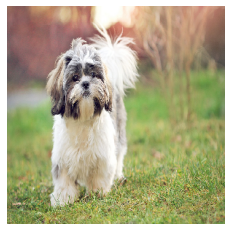

'shih-tzu'

In [57]:
img_path = 'Shih-Tzus.jpg'    
predict_from_image(img_path)